In [1]:
# import some of the libaries that we will use
import urllib.request
import io
import itertools as it
import os
import zipfile
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import re
import unicodedata
import string
from collections import defaultdict
import pickle


from thefuzz import process
from thefuzz import fuzz

import json

import colorcet as cc
import panel as pn
import panel.widgets as pnw

from translate_app import translate_list_to_dict
import recordlinkage as rl
import missingno as msno
import holoviews as hv
import hvplot
import hvplot.pandas
import geoviews as gv
import cartopy.crs as ccrs

In [2]:
pd.set_option("display.max_rows", 350)

In [3]:
# get the zip file with the data from the link


data_url = (
    "https://storage.googleapis.com/mrprimetranslator_datasets/dogs_of_zurich.zip"
)

# create function which takes the url
# retrieve zip and unzip it and return the csv files as a list


def get_data(url):
    """Function which takes in a url, retrieves the zip file,
    unzips it and returns the csv files as a list"""
    # get the zip file
    filename, headers = urllib.request.urlretrieve(url)
    with zipfile.ZipFile(filename) as zip_ref:
        # get the csv files
        dfs = []
        for file in zip_ref.namelist():
            if file.endswith(".csv"):
                csv_file = io.StringIO(zip_ref.read(file).decode("utf-8"))
                # readin csv as a pandas dataframe and append to list
                df = pd.DataFrame()
                df = pd.read_csv(csv_file)
                df["roster"] = file
                dfs.append(df)

    return dfs

In [4]:
# define a function to match breed names using FuzzyWuzzy
def match_breed_name(name, choices, scorer=fuzz.token_sort_ratio):
    if name in choices:
        return name, 100
    mismo, score, *_ = process.extractOne(name, choices, scorer=scorer)
    return mismo, score

In [5]:
# call the function and assign the csv files to a variable
dogs_of_zurich_dfs = get_data(data_url)
len(dogs_of_zurich_dfs)

4

In [6]:
for df in dogs_of_zurich_dfs:
    print(df.shape)
    display(df.sample(3))

(6980, 14)


,HALTER_ID,ALTER,GESCHLECHT,STADTKREIS,STADTQUARTIER,RASSE1,RASSE1_MISCHLING,RASSE2,RASSE2_MISCHLING,RASSENTYP,GEBURTSJAHR_HUND,GESCHLECHT_HUND,HUNDEFARBE,roster
4822,115158,31-40,w,9.0,92.0,Zwergpinscher,NaN,NaN,NaN,K,2010,m,schwarz/braun,20151001hundehalter.csv
2837,93664,61-70,w,7.0,74.0,Dachshund,NaN,NaN,NaN,K,2010,w,schwarz/rot,20151001hundehalter.csv
2919,94794,41-50,w,2.0,24.0,Yorkshire Terrier,NaN,NaN,NaN,K,2011,m,blue/tan,20151001hundehalter.csv


(6930, 14)


,HALTER_ID,ALTER,GESCHLECHT,STADTKREIS,STADTQUARTIER,RASSE1,RASSE1_MISCHLING,RASSE2,RASSE2_MISCHLING,RASSENTYP,GEBURTSJAHR_HUND,GESCHLECHT_HUND,HUNDEFARBE,roster
1258,85893,71-80,m,3.0,31.0,Border Terrier,NaN,NaN,NaN,K,2012,w,red grizzle,20160307hundehalter.csv
6292,127062,51-60,w,9.0,91.0,Labrador Retriever,NaN,NaN,NaN,I,2006,w,schwarz,20160307hundehalter.csv
5996,125397,31-40,w,7.0,74.0,Yorkshire Terrier,NaN,NaN,NaN,K,2012,m,beige/grau,20160307hundehalter.csv


(7155, 14)


,HALTER_ID,ALTER,GESCHLECHT,STADTKREIS,STADTQUARTIER,RASSE1,RASSE1_MISCHLING,RASSE2,RASSE2_MISCHLING,RASSENTYP,GEBURTSJAHR_HUND,GESCHLECHT_HUND,HUNDEFARBE,roster
1299,86602,51-60,m,2.0,21.0,Appenzeller,Mischling,NaN,NaN,I,2002,m,schwarz/braun/weiss,20170308hundehalter.csv
3676,107620,61-70,w,12.0,121.0,Airedale Terrier,NaN,NaN,NaN,I,2011,m,rot/schwarz,20170308hundehalter.csv
2572,95013,41-50,m,7.0,74.0,Jack Russel Terrier,NaN,NaN,NaN,K,2002,w,tricolor,20170308hundehalter.csv


(361, 4)


,HUNDERASSE,HUNDERASSENTYP_KURZ,HUNDERASSENTYP,roster
243,Papillon,K,Kleinwüchsig,zuordnungstabellehunderassehundetyp.csv
30,Basenji,K,Kleinwüchsig,zuordnungstabellehunderassehundetyp.csv
25,Australien Kelpie,I,Rassentypenliste I,zuordnungstabellehunderassehundetyp.csv


In [7]:
# Put all the column headers in one list
list_of_headings = []
for df in dogs_of_zurich_dfs:
    list_of_headings += df.columns.tolist()

more_german_words = list(
    filter(lambda x: x is not np.nan, dogs_of_zurich_dfs[3].iloc[:, 2].unique())
)
list_of_headings += more_german_words

In [8]:
# Only keep unique column headers and replace underscores with spaces

words_set = {word.replace("_", " ") for word in list_of_headings}
words_set

{'ALTER',
 'GEBURTSJAHR HUND',
 'GESCHLECHT',
 'GESCHLECHT HUND',
 'HALTER ID',
 'HUNDEFARBE',
 'HUNDERASSE',
 'HUNDERASSENTYP',
 'HUNDERASSENTYP KURZ',
 'Kleinwüchsig',
 'RASSE1',
 'RASSE1 MISCHLING',
 'RASSE2',
 'RASSE2 MISCHLING',
 'RASSENTYP',
 'Rassentypenliste I',
 'Rassentypenliste II',
 'STADTKREIS',
 'STADTQUARTIER',
 'roster'}

#### Run translate app for columns

In [9]:
translated_words = translate_list_to_dict(words_set)
translated_words

{'GESCHLECHT': 'GENDER',
 'STADTKREIS': 'CITY CIRCLE',
 'STADTQUARTIER': 'CITY QUARTER',
 'Rassentypenliste I': 'Breed type list I',
 'HUNDERASSENTYP': 'DOG BREED TYPE',
 'HALTER ID': 'HOLDER ID',
 'RASSE2 MISCHLING': 'BREED2 MIXED BREED',
 'ALTER': 'AGE',
 'RASSE1': 'BREED1',
 'RASSENTYP': 'BREED TYPE',
 'RASSE1 MISCHLING': 'BREED1 MIXED BREED',
 'HUNDEFARBE': 'DOG COLOR',
 'Kleinwüchsig': 'Short stature',
 'HUNDERASSE': 'DOG BREED',
 'GEBURTSJAHR HUND': "DOG'S YEAR OF BIRTH",
 'RASSE2': 'BREED2',
 'roster': 'roster',
 'HUNDERASSENTYP KURZ': 'DOG BREED TYPE SHORT',
 'Rassentypenliste II': 'List of breed types II',
 'GESCHLECHT HUND': 'GENDER DOG'}

In [10]:
# put the underscores back in the original headings
translated_headings_underscores = {
    key.replace(" ", "_"): value.lower().replace(" ", "_").replace("'s", "")
    for key, value in translated_words.items()
}
translated_headings_underscores

{'GESCHLECHT': 'gender',
 'STADTKREIS': 'city_circle',
 'STADTQUARTIER': 'city_quarter',
 'Rassentypenliste_I': 'breed_type_list_i',
 'HUNDERASSENTYP': 'dog_breed_type',
 'HALTER_ID': 'holder_id',
 'RASSE2_MISCHLING': 'breed2_mixed_breed',
 'ALTER': 'age',
 'RASSE1': 'breed1',
 'RASSENTYP': 'breed_type',
 'RASSE1_MISCHLING': 'breed1_mixed_breed',
 'HUNDEFARBE': 'dog_color',
 'Kleinwüchsig': 'short_stature',
 'HUNDERASSE': 'dog_breed',
 'GEBURTSJAHR_HUND': 'dog_year_of_birth',
 'RASSE2': 'breed2',
 'roster': 'roster',
 'HUNDERASSENTYP_KURZ': 'dog_breed_type_short',
 'Rassentypenliste_II': 'list_of_breed_types_ii',
 'GESCHLECHT_HUND': 'gender_dog'}

In [11]:
# This is actually translated to districts as in the 12 districts of Zurich
translated_headings_underscores["STADTKREIS"] = "district"
# owner may be a better translation than holder
translated_headings_underscores["HALTER_ID"] = "owner_id"

In [12]:
# put the translated headings as the new column names
for df in dogs_of_zurich_dfs:
    df.rename(columns=translated_headings_underscores, inplace=True)

#### Get the 2 dataframes

In [13]:
# Combine 3 of 4 dataframes into one with dog owner info
dog_owner_df = pd.DataFrame()
dog_owner_df = pd.concat(
    [dogs_of_zurich_dfs[0], dogs_of_zurich_dfs[1], dogs_of_zurich_dfs[2]], axis=0
)
dog_owner_df.info()

# name last dataframe with dog breeds info
dog_df = pd.DataFrame()
dog_df = dogs_of_zurich_dfs[3]
dog_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21065 entries, 0 to 7154
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   owner_id            21065 non-null  int64  
 1   age                 21060 non-null  object 
 2   gender              21065 non-null  object 
 3   district            21060 non-null  float64
 4   city_quarter        21060 non-null  float64
 5   breed1              21065 non-null  object 
 6   breed1_mixed_breed  1939 non-null   object 
 7   breed2              1590 non-null   object 
 8   breed2_mixed_breed  0 non-null      float64
 9   breed_type          20891 non-null  object 
 10  dog_year_of_birth   21065 non-null  int64  
 11  gender_dog          21065 non-null  object 
 12  dog_color           21065 non-null  object 
 13  roster              21065 non-null  object 
dtypes: float64(3), int64(2), object(9)
memory usage: 2.4+ MB
<class 'pandas.core.frame.DataFrame'>
RangeInd

In [14]:
display(dog_owner_df.sample(3))
display(dog_df.sample(3))

,owner_id,age,gender,district,city_quarter,breed1,breed1_mixed_breed,breed2,breed2_mixed_breed,breed_type,dog_year_of_birth,gender_dog,dog_color,roster
2869,99106,31-40,m,4.0,42.0,Mops,NaN,NaN,NaN,K,2006,m,schwarz,20170308hundehalter.csv
1012,84267,61-70,m,7.0,72.0,Bergamasker,Mischling,NaN,NaN,I,2002,w,grau/braun,20151001hundehalter.csv
5515,125475,51-60,w,5.0,52.0,Shih Tzu,NaN,NaN,NaN,K,2001,m,braun/weiss,20170308hundehalter.csv


,dog_breed,dog_breed_type_short,dog_breed_type,roster
37,Beauceron,I,Rassentypenliste I,zuordnungstabellehunderassehundetyp.csv
26,Azawakh,I,Rassentypenliste I,zuordnungstabellehunderassehundetyp.csv
294,Schäfer,I,Rassentypenliste I,zuordnungstabellehunderassehundetyp.csv


<Axes: >

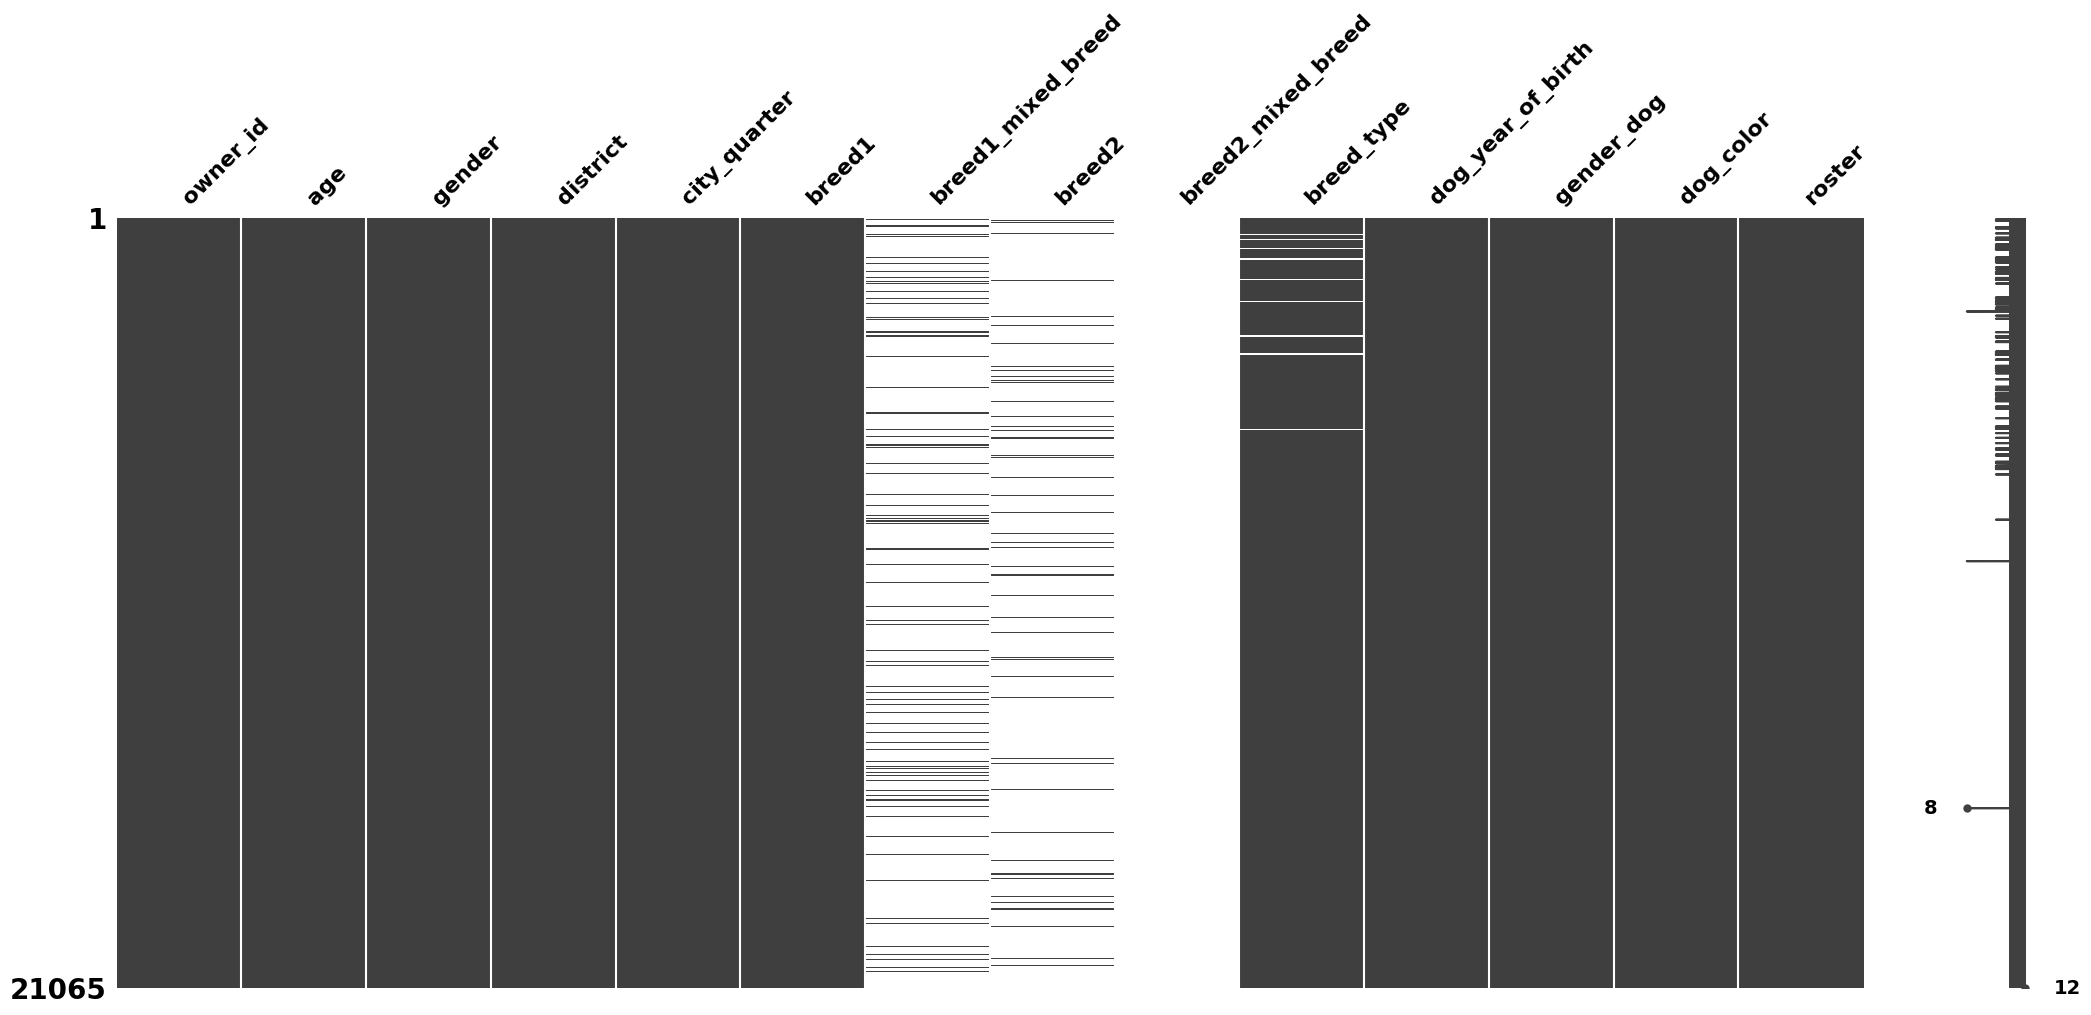

In [15]:
msno.matrix(dog_owner_df)

In [16]:
# only null values in breed2_mixed so drop column
dog_owner_df = dog_owner_df.drop(columns=["breed2_mixed_breed"])

<Axes: >

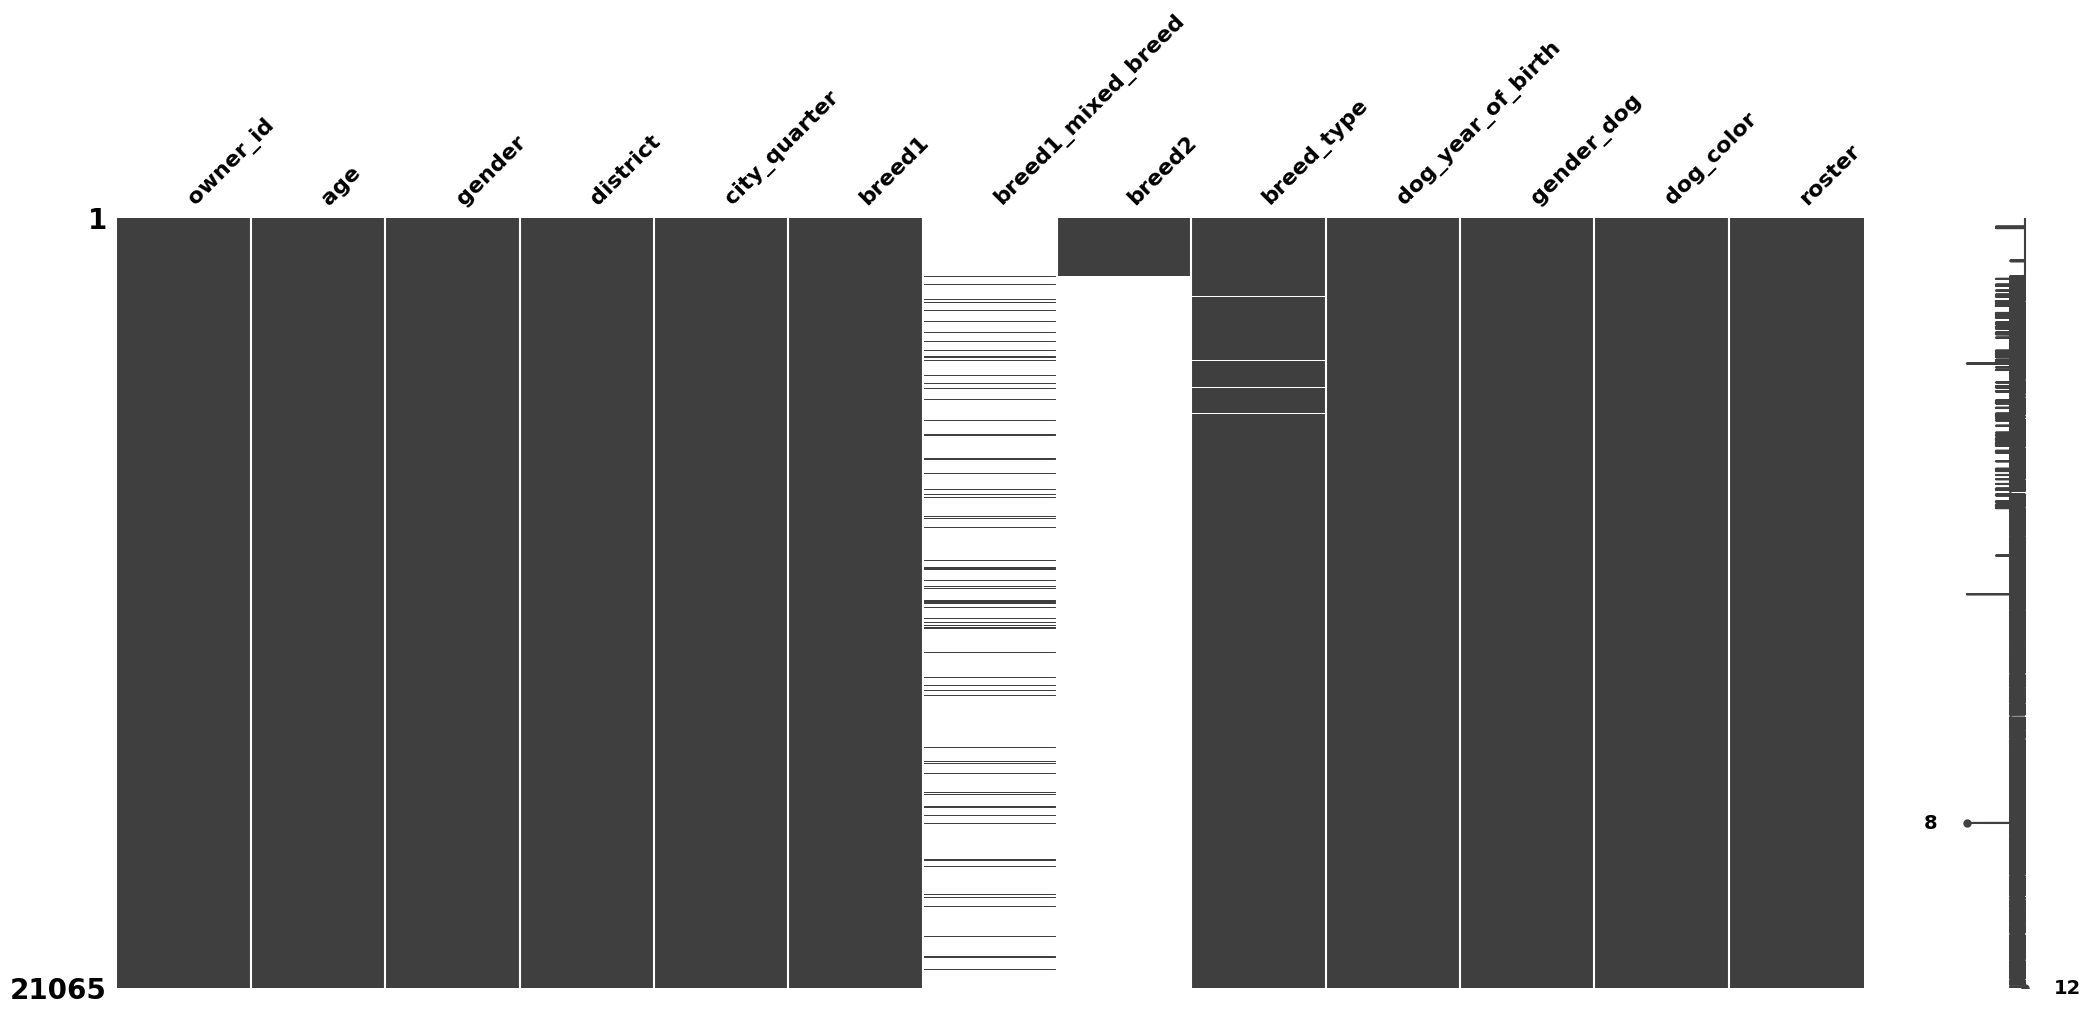

In [17]:
msno.matrix(dog_owner_df.sort_values(by=["breed2"]))

In [18]:
# reset index
dog_owner_df = dog_owner_df.reset_index(drop=True)
# make the district column a category
dog_owner_df["district"] = dog_owner_df["district"].astype("category")

# take the first 4 char of roster only and make it an ordered category colummn
dog_owner_df["roster"] = dog_owner_df["roster"].str[:4]
dog_owner_df["roster"] = pd.Categorical(dog_owner_df["roster"], ordered=True)


# add a column with the first year the owner appeared in the roster
dog_owner_df["first_appearance"] = dog_owner_df.groupby("owner_id")["roster"].transform(
    "min"
)

# add column for the number of appearances on the rosters(if it's their first, second, third, etc time on the roster)
dog_owner_df["appearances"] = dog_owner_df.groupby("owner_id")["roster"].transform(
    "nunique"
)

# add a column with the number of dogs per owner
dog_owner_df["dog_count"] = dog_owner_df.groupby(["owner_id", "roster"])[
    "owner_id"
].transform("size")

dog_owner_df.sample(3)

,owner_id,age,gender,district,city_quarter,breed1,breed1_mixed_breed,breed2,breed_type,dog_year_of_birth,gender_dog,dog_color,roster,first_appearance,appearances,dog_count
9946,98257,61-70,m,2.0,24.0,Münsterländer,Mischling,NaN,I,2007,w,rot/weiss,2016,2015,3,1
19999,129110,21-30,w,10.0,101.0,West Highland White Terrier,NaN,NaN,K,2008,w,weiss,2017,2016,2,1
16897,99808,41-50,w,3.0,33.0,Mops,NaN,NaN,K,2014,w,beige/schwarz,2017,2015,3,2


In [19]:
# check if any row with a value in breed2 has a value in breed1_mixed_breed
dog_owner_df[dog_owner_df["breed2"].notna()]["breed1_mixed_breed"].value_counts()


# if Mischling is in breed1 then breed1_mixed_breed should be Mischling
dog_owner_df.loc[
    (dog_owner_df["breed1"].str.contains("Mischling"))
    | (dog_owner_df["breed2"].notna()),
    "breed1_mixed_breed",
] = "Mischling"

# fill in the rest with pure_breed
dog_owner_df["breed1_mixed_breed"].fillna("pure_breed", inplace=True)
# check if any nan values left
dog_owner_df[dog_owner_df["breed1_mixed_breed"].isna()]

,owner_id,age,gender,district,city_quarter,breed1,breed1_mixed_breed,breed2,breed_type,dog_year_of_birth,gender_dog,dog_color,roster,first_appearance,appearances,dog_count


Dog with a year of birth after the roster year

In [20]:
# get the owner_id of the bad entries and observe other entries with the same owner_id
bad_entry_owner_id = dog_owner_df[
    dog_owner_df["dog_year_of_birth"] > dog_owner_df["roster"].astype(int)
]["owner_id"]


dog_owner_df[dog_owner_df["owner_id"].isin(bad_entry_owner_id)].sort_values(
    by="owner_id"
)

# dog_owner_df[dog_owner_df["owner_id"].isin(bad_entry_owner_id)].index

,owner_id,age,gender,district,city_quarter,breed1,breed1_mixed_breed,breed2,breed_type,dog_year_of_birth,gender_dog,dog_color,roster,first_appearance,appearances,dog_count
4543,111954,41-50,w,3.0,34.0,Parson Russell Terrier,pure_breed,NaN,K,5012,m,tricolor,2015,2015,2,1
11296,111954,51-60,w,3.0,34.0,Parson Russell Terrier,pure_breed,NaN,K,5012,m,tricolor,2016,2015,2,1
5608,121585,41-50,m,7.0,74.0,Malteser,pure_breed,NaN,K,2016,m,weiss,2015,2015,3,1
12282,121585,41-50,m,7.0,74.0,Malteser,pure_breed,NaN,K,2016,m,weiss,2016,2015,3,1
18798,121585,41-50,m,7.0,74.0,Malteser,pure_breed,NaN,K,2016,m,weiss,2017,2015,3,1


Since we have Rosters for 3 separate years, we can see if that owner corrected its wrong entry in the later years. We can drop since the bad entries are consistent with no clue as to the correct entry.

In [21]:
print("Shape of dataframe before dropping bad entries")
display(dog_owner_df.shape)

bad_entry_index = dog_owner_df[dog_owner_df["owner_id"].isin(bad_entry_owner_id)].index

dog_owner_df.drop(bad_entry_index, inplace=True)

print("Shape of dataframe after dropping bad entries")
display(dog_owner_df.shape)


display(dog_owner_df.info())

Shape of dataframe before dropping bad entries


(21065, 16)

Shape of dataframe after dropping bad entries


(21060, 16)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21060 entries, 0 to 21064
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   owner_id            21060 non-null  int64   
 1   age                 21055 non-null  object  
 2   gender              21060 non-null  object  
 3   district            21055 non-null  category
 4   city_quarter        21055 non-null  float64 
 5   breed1              21060 non-null  object  
 6   breed1_mixed_breed  21060 non-null  object  
 7   breed2              1590 non-null   object  
 8   breed_type          20886 non-null  object  
 9   dog_year_of_birth   21060 non-null  int64   
 10  gender_dog          21060 non-null  object  
 11  dog_color           21060 non-null  object  
 12  roster              21060 non-null  category
 13  first_appearance    21060 non-null  category
 14  appearances         21060 non-null  int64   
 15  dog_count           21060 non-null  

None

Dogs with a year of birth too far before the roster year (before 1990) which is plausible, but not probable

In [22]:
# get the owner_id of the bad entries
bad_entry_owner_id = dog_owner_df[dog_owner_df["dog_year_of_birth"] < 1990]["owner_id"]

# isolate entries from these owner_ids and group them by owner_id
dog_owner_group = (
    dog_owner_df[dog_owner_df["owner_id"].isin(bad_entry_owner_id)]
    .sort_values(by="owner_id")
    .groupby("owner_id")
)

dog_owner_df[dog_owner_df["owner_id"].isin(bad_entry_owner_id)].sort_values(
    by="owner_id"
)

,owner_id,age,gender,district,city_quarter,breed1,breed1_mixed_breed,breed2,breed_type,dog_year_of_birth,gender_dog,dog_color,roster,first_appearance,appearances,dog_count
2659,91351,41-50,m,7.0,72.0,Mops,pure_breed,NaN,K,1980,w,beige/schwarz,2015,2015,3,1
9485,91351,41-50,m,7.0,72.0,Mops,pure_breed,NaN,K,2009,w,beige/schwarz,2016,2015,3,1
16238,91351,41-50,m,7.0,72.0,Mops,pure_breed,NaN,K,2009,w,beige/schwarz,2017,2015,3,1
2901,94655,41-50,w,2.0,24.0,Labrador Retriever,pure_breed,NaN,I,8,w,braun,2015,2015,3,1
9712,94655,41-50,w,2.0,24.0,Labrador Retriever,pure_breed,NaN,I,2008,w,braun,2016,2015,3,1
16448,94655,41-50,w,2.0,24.0,Labrador Retriever,pure_breed,NaN,I,2008,w,braun,2017,2015,3,1
3165,98411,71-80,w,11.0,119.0,Labrador Retriever,pure_breed,NaN,I,1,w,schwarz,2015,2015,3,1
9966,98411,71-80,w,11.0,119.0,Labrador Retriever,pure_breed,NaN,I,2001,w,schwarz,2016,2015,3,1
16689,98411,71-80,w,11.0,119.0,Labrador Retriever,pure_breed,NaN,I,2001,w,schwarz,2017,2015,3,1
3521,100070,51-60,w,9.0,92.0,Pekingese,pure_breed,NaN,K,1962,m,braun/schwarz,2015,2015,3,1


We can replace bad entries with matching entries from the later roster years as the owner corrected the value for th elater rosters. Luckly these owners only have one dog each.

The one bad entry of `1980` with only 1 appearance we cannot safely replace so we drop it(`owner_id` 129251).

In [23]:
# these entries only have 1 dog so we can replace the year of birth with the mode making some assumptions
dog_owner_df.loc[
    dog_owner_df["owner_id"].isin(bad_entry_owner_id), "dog_year_of_birth"
] = dog_owner_group["dog_year_of_birth"].transform(lambda x: x.mode().iloc[0])

dog_owner_df[dog_owner_df["owner_id"].isin(bad_entry_owner_id)].sort_values(
    by="owner_id"
)

,owner_id,age,gender,district,city_quarter,breed1,breed1_mixed_breed,breed2,breed_type,dog_year_of_birth,gender_dog,dog_color,roster,first_appearance,appearances,dog_count
2659,91351,41-50,m,7.0,72.0,Mops,pure_breed,NaN,K,2009,w,beige/schwarz,2015,2015,3,1
9485,91351,41-50,m,7.0,72.0,Mops,pure_breed,NaN,K,2009,w,beige/schwarz,2016,2015,3,1
16238,91351,41-50,m,7.0,72.0,Mops,pure_breed,NaN,K,2009,w,beige/schwarz,2017,2015,3,1
2901,94655,41-50,w,2.0,24.0,Labrador Retriever,pure_breed,NaN,I,2008,w,braun,2015,2015,3,1
9712,94655,41-50,w,2.0,24.0,Labrador Retriever,pure_breed,NaN,I,2008,w,braun,2016,2015,3,1
16448,94655,41-50,w,2.0,24.0,Labrador Retriever,pure_breed,NaN,I,2008,w,braun,2017,2015,3,1
3165,98411,71-80,w,11.0,119.0,Labrador Retriever,pure_breed,NaN,I,2001,w,schwarz,2015,2015,3,1
9966,98411,71-80,w,11.0,119.0,Labrador Retriever,pure_breed,NaN,I,2001,w,schwarz,2016,2015,3,1
16689,98411,71-80,w,11.0,119.0,Labrador Retriever,pure_breed,NaN,I,2001,w,schwarz,2017,2015,3,1
3521,100070,51-60,w,9.0,92.0,Pekingese,pure_breed,NaN,K,2006,m,braun/schwarz,2015,2015,3,1


In [24]:
# the one with only 1 appearance we cannot safely replace so we drop it
dog_owner_df = dog_owner_df.drop(dog_owner_df[dog_owner_df["owner_id"] == 129251].index)

# No more 20/30something years-old dogs
dog_owner_df[dog_owner_df["dog_year_of_birth"] < 1990]["owner_id"]

Series([], Name: owner_id, dtype: int64)

Add 1 to the dog age so that no dog has an age of 0. Consider it the dog's year of living.

In [25]:
# dog's age is calculated by subtracting the year of birth from the year of the roster
# added 1 in case i wanted to do something with log down the line
dog_owner_df["dog_age"] = (
    dog_owner_df["roster"].astype(int) - dog_owner_df["dog_year_of_birth"] + 1
)


def dog_stage(age):
    """Function to categorize dog's age into stages"""
    if age <= 3:
        return "puppy"

    elif age <= 8:
        return "adult"
    elif age > 8:
        return "senior"
    else:
        return "no age given"


dog_owner_df["dog_stage"] = dog_owner_df["dog_age"].apply(dog_stage)
dog_owner_df.sample(3)
# dog_owner_df[dog_owner_df["owner_id"] == 135329]
dog_owner_df.groupby(["dog_stage", "roster"])["dog_stage"].count()

dog_stage  roster
adult      2015      2819
           2016      2865
           2017      2897
puppy      2015      1335
           2016       956
           2017      1047
senior     2015      2824
           2016      3106
           2017      3210
Name: dog_stage, dtype: int64

In [26]:
# dog_df[dog_df["dog_breed_type_short"] == "II"]
# dog_owner_df[dog_owner_df["breed_type"] == "II"].sort_values(by="owner_id")

In [27]:
# get the breeds for which there is a mixed breed but no pure breed
mixed_df = dog_owner_df[dog_owner_df["breed1_mixed_breed"] == "Mischling"]
print(f"Mixed dataframe shape: {mixed_df.shape}")

pure_df = dog_owner_df[dog_owner_df["breed1_mixed_breed"] == "pure_breed"]
print(f"Pure dataframe shape: {pure_df.shape}")

mixed_breeds = set(
    dog_owner_df[dog_owner_df["breed1_mixed_breed"] == "Mischling"]["breed1"].values
)
pure_breeds = set(
    dog_owner_df[dog_owner_df["breed1_mixed_breed"] == "pure_breed"]["breed1"].values
)

Mixed dataframe shape: (5913, 18)
Pure dataframe shape: (15146, 18)


In [28]:
dog_owner_df["age"].value_counts()

51-60     4558
41-50     4468
31-40     3941
61-70     3095
21-30     2337
71-80     1957
81-90      524
11-20      127
91-100      47
Name: age, dtype: int64

In [29]:
display(dog_owner_df[dog_owner_df.age.isnull()])


# Drop these 5 rows with unknown
dog_owner_df["age"].fillna("0", inplace=True)
dog_owner_df.dropna(subset=["age"], inplace=True)
dog_owner_df.shape

,owner_id,age,gender,district,city_quarter,breed1,breed1_mixed_breed,breed2,breed_type,dog_year_of_birth,gender_dog,dog_color,roster,first_appearance,appearances,dog_count,dog_age,dog_stage
1348,85988,NaN,m,2.0,2.0,Zwergpudel,pure_breed,NaN,K,2001,m,beige/weiss,2015,2015,2,1,15,senior
2556,90344,NaN,m,NaN,NaN,Shih Tzu,pure_breed,NaN,K,1998,w,schwarz,2015,2015,3,1,18,senior
8253,85988,NaN,m,2.0,2.0,Zwergpudel,pure_breed,NaN,K,2001,m,beige/weiss,2016,2015,2,1,16,senior
9387,90344,NaN,m,NaN,NaN,Shih Tzu,pure_breed,NaN,K,1998,w,schwarz,2016,2015,3,1,19,senior
16144,90344,NaN,m,NaN,NaN,Shih Tzu,pure_breed,NaN,K,1998,w,schwarz,2017,2015,3,1,20,senior


(21059, 18)

In [30]:
# owners each year
owner_2015 = set(dog_owner_df[dog_owner_df["roster"] == "2015"]["owner_id"])
owner_2016 = set(dog_owner_df[dog_owner_df["roster"] == "2016"]["owner_id"])
owner_2017 = set(dog_owner_df[dog_owner_df["roster"] == "2017"]["owner_id"])

print(f"{len(owner_2015)} initial owners in 2015")
# constant owners for all 3 years
new_2016 = owner_2016.difference(owner_2015)
returning_2016 = owner_2016.intersection(owner_2015)
print(f"{len(new_2016)} new owners in 2016 and {len(returning_2016)} returning owners")

new_2017 = owner_2017.difference(owner_2015.union(owner_2016))
returning_2017 = owner_2017.intersection(owner_2015.union(owner_2016))
print(f"{len(new_2017)} new owners in 2017 and {len(returning_2017)} returning owners")

constistent_owners = owner_2015.intersection(owner_2016).intersection(owner_2017)
print(f"{len(constistent_owners)} constant owners")

6314 initial owners in 2015
434 new owners in 2016 and 5838 returning owners
975 new owners in 2017 and 5472 returning owners
5075 constant owners


In [31]:
dog_owner_df["age"] = pd.Categorical(
    dog_owner_df["age"],
    ordered=True,
    categories=[
        "0",
        "11-20",
        "21-30",
        "31-40",
        "41-50",
        "51-60",
        "61-70",
        "71-80",
        "81-90",
        "91-100",
    ],
)


# dog_owner_df.plot(
#     kind="bar",
#     column="age",
#     by="roster",
#     bins=9,
#     figsize=(10, 5),
#     histtype="step",
# )
dog_owner_df.groupby(
    [
        "age",
        "roster",
    ]
).size().unstack().hvplot.bar(
    xlabel="",
    rot=90,
    legend=True,
    tools=["hover", "box_select"],
    title="Owners age distribution each roster",
)

:Bars   [age,roster]   (value)

In [32]:
def age_group(age):
    """Function which widen the age groups of the oldest and youngest dog owners"""
    if age == "71-80" or age == "81-90" or age == "91-100":
        return "71+"
    elif age == "11-20" or age == "21-30":
        return "11-30"

    else:
        return age


dog_owner_df["age_group"] = dog_owner_df["age"].apply(age_group).dropna()
dog_owner_df

,owner_id,age,gender,district,city_quarter,breed1,breed1_mixed_breed,breed2,breed_type,dog_year_of_birth,gender_dog,dog_color,roster,first_appearance,appearances,dog_count,dog_age,dog_stage,age_group
0,126,51-60,m,9.0,92.0,Welsh Terrier,pure_breed,NaN,K,2011,w,schwarz/braun,2015,2015,3,1,5,adult,51-60
1,574,61-70,w,2.0,23.0,Cairn Terrier,pure_breed,NaN,K,2002,w,brindle,2015,2015,3,1,14,senior,61-70
2,695,41-50,m,6.0,63.0,Labrador Retriever,pure_breed,NaN,I,2012,w,braun,2015,2015,3,1,4,adult,41-50
3,893,61-70,w,7.0,71.0,Mittelschnauzer,pure_breed,NaN,I,2010,w,schwarz,2015,2015,3,1,6,adult,61-70
4,1177,51-60,m,10.0,102.0,Shih Tzu,pure_breed,NaN,K,2011,m,schwarz/weiss,2015,2015,3,1,5,adult,51-60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21060,135718,31-40,m,9.0,91.0,Mischling gross,Mischling,NaN,I,2015,w,golden,2017,2017,1,1,3,puppy,31-40
21061,135725,31-40,w,7.0,74.0,Boxer,pure_breed,NaN,I,2016,w,gelb/weiss,2017,2017,1,1,2,puppy,31-40
21062,135726,11-20,w,11.0,111.0,Pinscher,pure_breed,NaN,K,2016,w,schwarz,2017,2017,1,1,2,puppy,11-30
21063,135728,31-40,w,7.0,72.0,Whippet,pure_breed,NaN,I,2016,w,vierfarbig,2017,2017,1,1,2,puppy,31-40


In [33]:
dog_owner_df["age_range"] = dog_owner_df["age"].str[:1] + "0s"

In [34]:
print(
    f"Number of null values in column 'breed_type': ",
    dog_owner_df.breed_type.isnull().sum(),
)

# get the breed1 for the entries with missing breed_type
breed_missing_breed_type = dog_owner_df[dog_owner_df["breed_type"].isnull()][
    "breed1"
].unique()

breed_missing_breed_type

Number of null values in column 'breed_type':  174


array(['Terrier', 'Pudel', 'Miniature Australien Shepard', 'Elo',
       'Dogo Canario', 'Schwedischer Vallhund', 'Spaniel', 'Daisy-Dog',
       'Deutscher Jagdterrier', 'Biewer Yorkshire Terrier'], dtype=object)

In [35]:
dog_owner_df.groupby(["breed_type", "roster"]).size().unstack().hvplot.bar(
    xlabel="",
    rot=90,
    legend=True,
    tools=["hover", "box_select"],
    title="Breed type distribution each roster",
)

:Bars   [breed_type,roster]   (value)

In [36]:
pd.set_option("display.max_rows", 100)
bully_breed = dog_owner_df[dog_owner_df.breed_type == "II"]["breed1"].unique().tolist()
dog_owner_df[dog_owner_df.breed1.isin(bully_breed)]
dog_owner_df[dog_owner_df.breed_type == "II"].sort_values(
    by="dog_count", ascending=False
)["owner_id"].nunique()

# bully_pattern = re.compile(r"[P|p]it\s?[B|b]ull|Staffordshire")

# dog_owner_df[
#     dog_owner_df["breed1"].str.contains(bully_pattern, na=False)
#     | dog_owner_df["breed2"].str.contains(bully_pattern, na=False)
# ]

27

In [37]:
# Find these breeds in the dog_df and get the breed_type from there
dog_df.drop("roster", axis=1, inplace=True)
dog_df[dog_df["dog_breed"].isin(breed_missing_breed_type)]

,dog_breed,dog_breed_type_short,dog_breed_type
55,Biewer Yorkshire Terrier,NaN,NaN
104,Daisy-Dog,NaN,NaN
112,Deutscher Jagdterrier,NaN,NaN
124,Dogo Canario,NaN,NaN
126,Elo,NaN,NaN
221,Miniature Australien Shepard,NaN,NaN
269,Pudel,NaN,NaN
291,Schwedischer Vallhund,NaN,NaN
311,Spaniel,NaN,NaN
320,Terrier,NaN,NaN


In [38]:
# see what other dogs of these breeds have as breed_type
dog_owner_df[dog_owner_df["breed1"].isin(breed_missing_breed_type)].sort_values(
    by=["breed1", "owner_id"]
)

dog_breed_group = dog_owner_df[
    dog_owner_df["breed1"].isin(breed_missing_breed_type)
].groupby("breed1")

# most breeds have a unanimous breed_type so we can just fillna with the mode
display(dog_breed_group["breed_type"].value_counts())


# Fill in the missing breed_type with the mode of the breed1
dog_owner_df["breed_type"].fillna(
    dog_owner_df.groupby("breed1")["breed_type"].transform(lambda x: x.mode().iloc[0]),
    inplace=True,
)

dog_owner_df.info()

breed1                        breed_type
Biewer Yorkshire Terrier      K              20
Daisy-Dog                     K               2
Deutscher Jagdterrier         K               4
Dogo Canario                  I               7
Elo                           I               3
Miniature Australien Shepard  K              14
Pudel                         K             216
                              I               5
Schwedischer Vallhund         K               2
Spaniel                       K              13
Terrier                       K             123
                              I               2
Name: breed_type, dtype: int64

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21059 entries, 0 to 21064
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   owner_id            21059 non-null  int64   
 1   age                 21059 non-null  category
 2   gender              21059 non-null  object  
 3   district            21054 non-null  category
 4   city_quarter        21054 non-null  float64 
 5   breed1              21059 non-null  object  
 6   breed1_mixed_breed  21059 non-null  object  
 7   breed2              1590 non-null   object  
 8   breed_type          21059 non-null  object  
 9   dog_year_of_birth   21059 non-null  int64   
 10  gender_dog          21059 non-null  object  
 11  dog_color           21059 non-null  object  
 12  roster              21059 non-null  category
 13  first_appearance    21059 non-null  category
 14  appearances         21059 non-null  int64   
 15  dog_count           21059 non-null  

In [39]:
missing_district_owner_id = dog_owner_df[dog_owner_df["district"].isna()][
    "owner_id"
].unique()

dog_owner_df[dog_owner_df["owner_id"].isin(missing_district_owner_id)]

# drop these missing rows with no district info
# dog_owner_df.dropna(subset=["district"], inplace=True)

# dog_owner_df.info()
dog_owner_df[dog_owner_df["owner_id"] == 6364]

,owner_id,age,gender,district,city_quarter,breed1,breed1_mixed_breed,breed2,breed_type,dog_year_of_birth,gender_dog,dog_color,roster,first_appearance,appearances,dog_count,dog_age,dog_stage,age_group,age_range
36,6364,61-70,m,NaN,NaN,Appenzeller,Mischling,Border Collie,I,2013,m,tricolor,2015,2015,2,1,3,puppy,61-70,60s
7014,6364,61-70,m,NaN,NaN,Appenzeller,Mischling,Border Collie,I,2013,m,tricolor,2016,2015,2,1,4,adult,61-70,60s


In [40]:
# Convert the string columns to lower case
breed_columns = ["breed1", "breed2", "breed1_mixed_breed", "breed_type"]
# for col in breed_columns:
#     dog_owner_df[col] = dog_owner_df[col].str.lower()

dog_owner_df.sample(3)

,owner_id,age,gender,district,city_quarter,breed1,breed1_mixed_breed,breed2,breed_type,dog_year_of_birth,gender_dog,dog_color,roster,first_appearance,appearances,dog_count,dog_age,dog_stage,age_group,age_range
9367,89774,31-40,w,3.0,31.0,Parson Jack Russell Terrier,pure_breed,NaN,K,2004,m,weiss/rot,2016,2015,3,1,13,senior,31-40,30s
5610,121589,11-20,w,9.0,92.0,Chihuahua,pure_breed,NaN,K,2013,m,weiss/braun,2015,2015,2,1,3,puppy,11-30,10s
18965,122723,41-50,w,11.0,111.0,Labrador Retriever,pure_breed,NaN,I,2012,w,schwarz,2017,2015,3,1,6,adult,41-50,40s


In [41]:
# change the breed1_mixed_breed of the doodles to mischling and put the respective breed1 and breed2 values
doodle_mask = dog_owner_df["breed1"].str.contains("doodle", case=False)
dog_owner_df.loc[doodle_mask, "breed1_mixed_breed"] = "Mischling"

In [42]:
# put poodle in all the doodle breed2 entries

dog_owner_df.loc[doodle_mask, "breed2"] = "Poodle"

In [43]:
dog_owner_df.loc[
    dog_owner_df["breed1"].str.contains("labradoodle", case=False), "breed1"
] = "Labrador Retriever"
dog_owner_df.loc[
    dog_owner_df["breed1"].str.contains("goldendoodle", case=False), "breed1"
] = "Golden Retriever"

In [44]:
# dog_owner_df["breed1_mixed_breed"].nunique()
# dog_owner_df[breed_columns].describe()
# dog_df["dog_breed"].unique()
# dog_owner_df["breed1"].dropna().unique().tolist()

In [45]:
# Fix the misspelling of some of the breeds
dog_owner_df["breed1"] = dog_owner_df["breed1"].apply(
    lambda x: re.sub(r"(\w+)(terrier)", r"\1 \2", x, flags=re.IGNORECASE)
)


dog_owner_df["breed1"] = dog_owner_df["breed1"].str.replace(
    "viszla", "vizsla", case=False
)

dog_owner_df["breed2"].value_counts()

Labrador Retriever          121
Poodle                       99
Golden Retriever             67
Pudel                        66
Chihuahua                    65
                           ... 
Lhasa Apso                    1
Harzer Fuchs                  1
Toypudel                      1
American Pitbull Terrier      1
Podenco Ibicenco              1
Name: breed2, Length: 131, dtype: int64

In [46]:
# get all of the dog breeds to translate and put in a list
breed_list1 = dog_owner_df[["breed1", "breed2"]].stack().dropna().unique().tolist()
breed_list2 = dog_df["dog_breed"].unique().tolist()
breed_list3 = list(
    filter(lambda x: x is not np.nan, dog_owner_df["breed1_mixed_breed"].unique())
)
print(f"Length of breed_list1: {len(breed_list1)}")
print(f"Length of breed_list2: {len(breed_list2)}")


only_in_breed2 = set(breed_list2).difference(set(breed_list1))
print(f"Length of only_in_breed2: {len(only_in_breed2)}")
print(only_in_breed2)
breed_set = set(breed_list1 + breed_list2)
len(breed_set)
# breed_set
unmatched_breeds_df = pd.DataFrame()
unmatched_breeds_df["breed"] = list(breed_set)
unmatched_breeds_df
unmatched_breeds_df[
    unmatched_breeds_df["breed"].str.contains(
        "Mischling|klein|gross", regex=True, case=False
    )
]

Length of breed_list1: 316
Length of breed_list2: 360
Length of only_in_breed2: 52
{'Italienischer Laufhund', 'Stabijhoun', 'Deutscher Langhaarvorstehhund', 'Bullterrier', 'Braque', 'Italienische Bracke', 'Bichon à poil frisé', 'Kaukasischer Schäfer', 'Portugiesischer Hirtenhund', 'Dürbächler', 'Old English  Sheepdog', 'Puli Ungarischer Hirtenhund', 'Basset Fauve de Bretagne', 'Kanadischer Schäfer', 'Hannoverscher', 'Labrador Bless', 'Pon Hirtenhund', 'lunde', 'Langhaarschäfer', 'Danish-Swedish Farmdog', 'Mastino Napoletano', 'Petit bleu de Gascogne', 'Elo klein', 'Västgötaspets', 'Bluthund', 'Polarspitz', 'Elo gross', 'Barzoi', 'Broholmer', 'Foo Dog klein', 'Anatolian Kangal', 'Bulgarischer', 'Bedlington Terrier', 'German Shepard', 'Trüffelhund', 'Englischer', 'Goldendoodle', 'American Pit Bull Terrier', 'Westfalenterrier', 'Fuchs Terrier', 'Boxer Terrier', 'Iberischer Laufhund', 'American Akita', 'Tamaskan', 'Red Heeler', 'Kanaan', 'Australian working Kelpie', 'Bichon Löwenherz', 'Ma

,breed
32,Elo gross
33,Foo Dog klein
108,Elo klein
119,Mischling klein
136,Kleinspitz
138,Foo Dog gross
274,Grosspudel
298,Deutscher Grossspitz
315,Kleiner Münsterländer
348,Mischling gross


In [47]:
breed_dict = defaultdict(list)
set(breed_list1)

{'Affenpinscher',
 'Afghane',
 'Afghanischer Windhund',
 'Airedale Terrier',
 'Akita Inu',
 'Alano',
 'Alaskan Malamute',
 'Alpenländische Dachsbracke',
 'Altdeutscher Hütehund',
 'Altdeutscher Schäfer',
 'American Bulldog',
 'American Cocker Spaniel',
 'American Pitbull Terrier',
 'American Staffordshire Terrier',
 'Anatolischer Hirtenhund',
 'Appenzeller',
 'Appenzeller Sennenhund',
 'Australian Cattle Dog',
 'Australian Shepherd',
 'Australian Silky Terrier',
 'Australian Terrier',
 'Australien Kelpie',
 'Azawakh',
 'Barbet',
 'Bardino',
 'Basenji',
 'Basset',
 'Basset Griffon vendéen',
 'Basset Hound',
 'Bayerischer Gebirgsschweisshund',
 'Beagle',
 'Bearded Collie',
 'Beauceron',
 'Beauceron Berge de Beauce',
 'Belgischer Schäfer',
 'Bergamasker',
 'Berger Picard',
 'Berger blanc Suisse',
 'Berger de Beauce',
 'Berger de Brie',
 'Berger des Pyrenées',
 'Berner Sennenhund',
 'Bernhardiner',
 'Bichon',
 'Bichon Havanais',
 'Bichon frisé',
 'Bichon maltais',
 'Biewer Yorkshire Terrie

In [48]:
# breed_list1 = ["Pitbull", "German Shepherd", "Golden Retriever"]
# breed_list2 = ["Labrador Retriever", "Poodle", "Pit Bull"]

bully_pattern = re.compile(r"[P|p]it\s?[B|b]ull")
russel_pattern = re.compile(r"([P|p]arson|[J|j]ack|[R|r]ussel[l]?)+")

list(filter(bully_pattern.findall, sorted(breed_set)))
list(filter(russel_pattern.findall, sorted(breed_set)))

['Jack Russel Terrier',
 'Parson Jack Russell Terrier',
 'Parson Russell Terrier',
 'Parson Terrier']

#### Get the AKC breeds saved to disk

In [49]:
with open("../data/breed_standards.pkl", "rb") as f:
    breed_standards = pickle.load(f)
breed_standards


len(breed_standards.keys())

385

In [50]:
pd.set_option("display.max_rows", 350)


def remove_accents(input_str):
    """Function to remove accents from a string.
    It takes as argument a string and returns the same string
    without accents."""
    nfkd_form = (
        unicodedata.normalize("NFKD", input_str).encode("ASCII", "ignore").decode()
    )
    # return "".join([c for c in nfkd_form if not unicodedata.combining(c)])
    return nfkd_form


remove_accents("résuméö")

'resumeo'

In [51]:
def find_query(query, breed_standards=breed_standards):
    pattern = re.compile(query, re.IGNORECASE)
    query_result = [
        key
        for key, value in breed_standards.items()
        if any(pattern.search(v) for v in value)
    ]
    if len(query_result) > 0:
        for q in query_result:
            return q, breed_standards[q]
    return None, None

In [302]:
boas_list = [
    "english bulldog",
    "pug",
    "french bulldog",
    "boston terrier",
    "boxer",
    "shih tzu",
    "lhasa apso",
    "bullmastiff",
    "pekingese",
    "chinese shar-pei",
]

boas_dict = {breed: find_query(breed) for breed in boas_list}
dog_df["query_match"] = dog_df["dog_breed"].apply(lambda x: find_query(x)[0])
dog_df[dog_df["query_match"].notnull()]["dog_breed"]
# dog_df
# search_akc_breed("swiss")

0                           Affenpinscher
2                   Afghanischer Windhund
3                        Airedale Terrier
6                        Alaskan Malamute
7              Alpenländische Dachsbracke
10                         American Akita
11                       American Bulldog
12                American Cocker Spaniel
15         American Staffordshire Terrier
18                            Appenzeller
19                 Appenzeller Sennenhund
20                  Australian Cattle Dog
21                    Australian Shepherd
22               Australian Silky Terrier
23                     Australian Terrier
26                                Azawakh
27                                 Barbet
29                                 Barzoi
30                                Basenji
31                                 Basset
32               Basset Fauve de Bretagne
34        Bayerischer Gebirgsschweisshund
35                                 Beagle
36                         Bearded

In [52]:
# all_breeds is a list of all breeds from the breeds in the breed_standards dictionary values
all_breeds = list(it.chain.from_iterable(v for v in breed_standards.values()))

# breed_map is a dictionary mapping each unique breed in dog_owner_df to the closest match in the breed_standards dictionary.
# If no match is found, the breed is mapped to None.
breed_map = defaultdict(set)
# unmatched is a list of breeds with no match in the breed_standards dictionary.


for breed in set(dog_owner_df["breed1"].unique()):
    breed_map[breed] = find_query(breed)[0]
unmatched = sorted([k for k, v in breed_map.items() if v is None])

# unmatched_df is a DataFrame with the breeds in unmatched as rows.
unmatched_df = pd.DataFrame(unmatched, columns=["breed"])


# unmatched_df["closest_match"] is a column with the closest match found in all_breeds for each breed in unmatched.
# unmatched_df["match_score"] is a column with the match score for each breed in unmatched.
unmatched_df["closest_match"], unmatched_df["match_score"] = zip(
    *unmatched_df["breed"].apply(
        lambda x: match_breed_name(x, all_breeds, scorer=fuzz.token_set_ratio)
    )
)


# unmatched_df["standard"] is a column with the standard for each breed in unmatched with a match score > 80.
unmatched_df["standard"] = unmatched_df[unmatched_df["match_score"] > 80][
    "closest_match"
].apply(lambda x: [key for key, value in breed_standards.items() if x in value][0])


# breed_map is updated with the standard for each breed in unmatched with a match score > 80.
for row in unmatched_df[unmatched_df["standard"].notna()].iterrows():
    breed_map[row[1]["breed"]] = find_query(row[1]["standard"])[0]

In [53]:
# Unmatched ones are the keys with no value pair
unmatched = sorted([k for k, v in breed_map.items() if v is None])


unmatched

['Afghane',
 'Alano',
 'Anatolischer Hirtenhund',
 'Bardino',
 'Berger des Pyrenées',
 'Bulgarischer Sennenhund',
 'Chinese Powder Puff',
 'Corgie',
 'Dackel',
 'Daisy-Dog',
 'Deutscher Langhaarschäfer',
 'Dogo Canario',
 'Englische Bulldogge',
 'Foo Dog gross',
 'Grosspudel',
 'Harzer Fuchs',
 'Kleinspitz',
 'Kurzhaar Dackel',
 'Königspudel',
 'Langhaardackel',
 'Maremma-Abruzzenhund',
 'Miniature Australien Shepard',
 'Mischling gross',
 'Mischling klein',
 'Mittelpudel',
 'Mittelschnauzer',
 'Mittelspitz',
 'Old Englische Bulldogge',
 'Powder Puff',
 'Ratenero Bodeguero',
 'Ratero',
 'Rauhaar Dackel',
 'Sibirischer Husky',
 'Toller',
 'Toypudel',
 'Welsh Corgi Cardigan',
 'Welsh Corgi Pembroke',
 'Westgotenspitz',
 'Wolfspitz',
 'Wäller',
 'Zwergdachshund',
 'Zwergdackel',
 'Zwergpudel',
 'Zwergrauhaardackel',
 'Zwergspitz']

#### Run translate app for breeds

In [54]:
# translate the dog breeds
# unmatched_translations = translate_list_to_dict(unmatched_breeds)
unmatched_translations = translate_list_to_dict(unmatched)
unmatched_translations

{'Afghane': 'Afghan',
 'Alano': 'Alano',
 'Anatolischer Hirtenhund': 'Anatolian Shepherd Dog',
 'Bardino': 'Bardino',
 'Berger des Pyrenées': 'Berger des Pyrenees',
 'Bulgarischer Sennenhund': 'Bulgarian Mountain Dog',
 'Chinese Powder Puff': 'Chinese Powder Puff',
 'Corgie': 'Corgie',
 'Dackel': 'dachshund',
 'Daisy-Dog': 'Daisy Dog',
 'Deutscher Langhaarschäfer': 'German longhair shepherd',
 'Dogo Canario': 'Dogo Canario',
 'Englische Bulldogge': 'English bulldog',
 'Foo Dog gross': 'Foo Dog large',
 'Grosspudel': 'Standard Poodle',
 'Harzer Fuchs': 'Harz Fox',
 'Kleinspitz': 'Small Spitz',
 'Kurzhaar Dackel': 'Shorthair Dachshund',
 'Königspudel': 'Royal Poodle',
 'Langhaardackel': 'Long-haired dachshund',
 'Maremma-Abruzzenhund': 'Maremma Abruzzo Dog',
 'Miniature Australien Shepard': 'Miniature Australia Shepard',
 'Mischling gross': 'Mixed breed big',
 'Mischling klein': 'Mixed breed small',
 'Mittelpudel': 'Middle Poodle',
 'Mittelschnauzer': 'Medium Schnauzer',
 'Mittelspitz': 

In [55]:
for k, v in unmatched_translations.items():
    breed_map[k] = find_query(v)[0]
unmatched_df = pd.DataFrame(
    unmatched_translations.items(), columns=["breed", "breed_en"]
)
# unmatched_df.columns = ["breed", "breed_en"]
unmatched_df["closest_match"], unmatched_df["match_score"] = zip(
    *unmatched_df["breed_en"].apply(
        lambda x: match_breed_name(x, all_breeds, scorer=fuzz.token_set_ratio)
    )
)
unmatched_df["standard"] = unmatched_df[unmatched_df["match_score"] > 80][
    "closest_match"
].apply(lambda x: [key for key, value in breed_standards.items() if x in value][0])
# display(unmatched_df.sort_values(by="match_score", ascending=False))
for row in unmatched_df[unmatched_df["standard"].notna()].iterrows():
    breed_map[row[1]["breed"]] = find_query(row[1]["standard"])[0]

In [235]:
unmatched = sorted([k for k, v in breed_map.items() if v is None])
# this is a more likely match than the Swiss white shepard dog
breed_map["Schäfer"] = "GERMAN SHEPHERD DOG"
breed_map["Englische Bulldogge"] = "BULLDOG"
sorted_breed_map = {k: breed_map[k] for k in sorted(breed_map)}
sorted_breed_map


# len(unmatched)

# get the keys with APPENZELL CATTLE DOG as the value
{k: v for k, v in breed_map.items() if v == "APPENZELL CATTLE DOG"}
# unmatched

{'Appenzeller': 'APPENZELL CATTLE DOG',
 'Cattle Dog': 'APPENZELL CATTLE DOG',
 'Bouvier': 'APPENZELL CATTLE DOG',
 'Sennenhund': 'APPENZELL CATTLE DOG',
 'Appenzeller Sennenhund': 'APPENZELL CATTLE DOG'}

In [57]:
# Map the breed1 column to the breed_map dictionary fo the 'standard'
dog_owner_df["breed1_std"] = dog_owner_df["breed1"].map(breed_map)
dog_owner_df["breed1_std"] = dog_owner_df["breed1_std"].str.upper()

In [58]:
dog_owner_df["city_quarter"].astype("string").value_counts().sort_index()

101.0    1409
102.0     636
11.0      192
111.0    1226
115.0    1059
119.0    1240
12.0       24
121.0     343
122.0     643
123.0     510
13.0       86
14.0       56
2.0         2
21.0      898
23.0      372
24.0      567
31.0      803
33.0      468
34.0      653
4.0         3
41.0      166
42.0      528
44.0      422
51.0      305
52.0      331
6.0         3
61.0      808
63.0      669
71.0      708
72.0      746
73.0      486
74.0     1050
81.0      352
82.0      370
83.0      391
91.0      888
92.0     1641
Name: city_quarter, dtype: Int64

In [59]:
dog_owner_df.loc[
    dog_owner_df["breed1"].str.contains("mischling", case=False), "breed1_std"
] = "Mischling".upper()
dog_owner_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21059 entries, 0 to 21064
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   owner_id            21059 non-null  int64   
 1   age                 21059 non-null  category
 2   gender              21059 non-null  object  
 3   district            21054 non-null  category
 4   city_quarter        21054 non-null  float64 
 5   breed1              21059 non-null  object  
 6   breed1_mixed_breed  21059 non-null  object  
 7   breed2              1683 non-null   object  
 8   breed_type          21059 non-null  object  
 9   dog_year_of_birth   21059 non-null  int64   
 10  gender_dog          21059 non-null  object  
 11  dog_color           21059 non-null  object  
 12  roster              21059 non-null  category
 13  first_appearance    21059 non-null  category
 14  appearances         21059 non-null  int64   
 15  dog_count           21059 non-null  

In [60]:
dog_owner_df[dog_owner_df["breed1_std"].isna()]["breed1"].value_counts()

Kleinspitz                      28
Miniature Australien Shepard    21
Welsh Corgi Pembroke            16
Mittelspitz                     12
Dogo Canario                    10
Ratero                           9
Welsh Corgi Cardigan             8
Foo Dog gross                    7
Bardino                          6
Maremma-Abruzzenhund             6
Ratenero Bodeguero               6
Daisy-Dog                        3
Alano                            3
Chinese Powder Puff              3
Wolfspitz                        3
Wäller                           3
Westgotenspitz                   2
Bulgarischer Sennenhund          2
Harzer Fuchs                     2
Corgie                           2
Powder Puff                      1
Name: breed1, dtype: int64

In [61]:
breed_counts_df = (
    dog_owner_df[["roster", "breed1_std"]]
    .groupby(["roster", "breed1_std"], as_index=False)
    .size()
    .pivot(index="breed1_std", columns="roster", values="size")
)
breed_counts_df["d_2016"] = breed_counts_df["2016"] - breed_counts_df["2015"]
breed_counts_df["d_2017"] = breed_counts_df["2017"] - breed_counts_df["2015"]
breed_counts_df.sort_values(by="2017", ascending=False).head(50)

dog_owner_df["dog_age"] = dog_owner_df["dog_age"].astype(int)
med_age_df = (
    dog_owner_df[["breed1_std", "dog_age", "roster"]]
    .groupby(["breed1_std", "roster"], as_index=False)
    .median()
    .pivot(index="breed1_std", columns="roster", values="dog_age")
    # .sort_values(by="2017", ascending=False)
    # .head(50)
)
med_age_df[med_age_df.index.str.contains("bull", regex=True, case=False)]

roster,2015,2016,2017
breed1_std,,,
BULL TERRIER,13.0,14.0,15.0
BULLDOG,4.0,5.0,5.5
BULLMASTIFF,5.5,5.0,7.5
CONTINENTAL BULLDOG,6.0,7.0,7.5
FRENCH BULLDOG,4.0,5.0,5.0
MINIATURE BULL TERRIER,3.5,4.0,3.5
STAFFORDSHIRE BULL TERRIER,10.0,11.0,12.5


In [62]:
# Lookin gat only purebred dogs, group by roster and get top10
only_purebred = dog_owner_df[dog_owner_df["breed1_mixed_breed"] == "pure_breed"]

grouped_roster = (
    dog_owner_df.groupby(
        ["roster", "breed1_std"],
        as_index=False,
    )
    .size()
    .reset_index()
)


grouped_roster = (
    only_purebred.groupby(["roster", "breed1_std"]).size().reset_index(name="counts")
)
top_breeds_per_roster = (
    grouped_roster.groupby("roster", as_index=False)
    .apply(lambda x: x.nlargest(10, "counts"))
    .reset_index(drop=True)
)

In [63]:
# Now you can plot the data
import plotly.express as px

# Sort the DataFrame by 'roster' and 'color'
# top_breeds_per_roster = top_breeds_per_roster.sort_values(["roster", "counts"])

# create a color map to highlight certain breeds
highlights = {"FRENCH BULLDOG": "red", "YORKSHIRE TERRIER": "red"}
highlights.update(
    {
        breed: "lightgray"
        for breed in top_breeds_per_roster["breed1_std"].unique()
        if breed not in highlights.keys()
    }
)

# Plot the data
fig = px.bar(
    top_breeds_per_roster,
    x="counts",
    y="breed1_std",
    color="breed1_std",
    orientation="h",
    title="Top Breeds per Roster",
    labels={"counts": "", "breed1_std": ""},
    color_discrete_map=highlights,
    facet_col="roster",
    height=500,
)
fig.update_traces(hovertemplate="Breed: %{y}<br>Count: %{x}")
fig.update_layout(showlegend=False)
fig.show()

In [64]:
def search_listed_dogs(breed):
    if breed is not None:
        pattern = re.compile(
            r"rottweiler|doberman|staffordshire|dogo|fila|bull terrier",
            flags=re.IGNORECASE,
        )
        if re.search(
            pattern,
            breed,
        ):
            return True
    return False


listed_dogs = dog_owner_df[
    dog_owner_df["breed1_std"].apply(lambda x: search_listed_dogs(x))
]


grouped_listed_dog_roster = (
    listed_dogs.groupby(["roster", "breed1_std"])
    .size()
    .reset_index(name="counts")
    .sort_values(by="counts", ascending=False)
)

fig = px.bar(
    grouped_listed_dog_roster,
    x="counts",
    y="breed1_std",
    orientation="h",
    title="Listed Breeds per Roster",
    labels={"counts": "", "breed1_std": ""},
    facet_col="roster",
    height=500,
)
fig.update_traces(hovertemplate="Breed: %{y}<br>Count: %{x}")
fig.update_layout(showlegend=False)
fig.show()

In [262]:
def search_swiss(breed):
    if breed is not None:
        pattern = re.compile(r"swiss|bern|appenz|entle", flags=re.IGNORECASE)
        if re.search(
            pattern,
            breed,
        ):
            return True
    return False


swiss_dogs = only_purebred[only_purebred["breed1_std"].apply(lambda x: search_swiss(x))]
display(swiss_dogs.groupby(["roster", "district"]).size().unstack().T)

# get the most popular breed in each district
swiss_dogs.groupby(["roster", "district"], as_index=False)["breed1_std"].agg(
    lambda x: x.value_counts().index[0]
).pivot(index="district", columns="roster", values="breed1_std")
# only_purebred["breed1_std"].value_counts().head(20)

swiss_dogs.groupby(
    [
        "breed1_std",
        "roster",
    ],
    as_index=False,
).size().pivot(index="breed1_std", columns="roster", values="size")

roster,2015,2016,2017
district,,,
1.0,1,1,2
2.0,12,12,14
3.0,8,11,10
4.0,2,1,2
5.0,2,3,3
6.0,10,8,9
7.0,13,14,13
8.0,7,7,7
9.0,8,8,9


roster,2015,2016,2017
breed1_std,,,
APPENZELL CATTLE DOG,21,20,21
BERNESE MOUNTAIN DOG,50,51,54
ENTLEBUCH CATTLE DOG,8,6,7
GREAT SWISS MOUNTAIN DOG,5,6,7
SMALL SWISS HOUND,3,3,3
ST. BERNARD,2,1,3
WHITE SWISS SHEPHERD DOG,5,5,7


In [275]:
highlights = {"BERNESE MOUNTAIN DOG": "red"}
highlights.update(
    {
        breed: "lightgray"
        for breed in swiss_dogs["breed1_std"].unique()
        if breed not in highlights.keys()
    }
)
swiss_grouped = (
    swiss_dogs.groupby(["roster", "breed1_std"])
    .size()
    .reset_index(name="counts")
)
# plot bar chart
fig = px.bar(
    swiss_grouped,
    x="counts",
    y="breed1_std",
    color="breed1_std",
    orientation="h",
    title="Swiss Breeds per Roster",
    labels={"count": "", "breed1_std": ""},
    color_discrete_map=highlights,
    facet_col="roster",
    height=500,
)
fig.update_traces(hovertemplate="Breed: %{y}<br>Count: %{x}")
fig.update_layout(showlegend=False)

In [66]:
dog_owner_df[dog_owner_df["breed1_mixed_breed"] == "pure_breed"][
    "breed1"
].value_counts()
dog_owner_df[~dog_owner_df["breed1_mixed_breed"].str.contains("pure_breed")][
    "breed1"
].value_counts()
dog_owner_df[dog_owner_df["dog_count"] == 1].sort_values(by=["owner_id", "roster"])
dog_count = dog_owner_df["dog_count"].value_counts().sort_index()

px.bar(
    dog_count, x=dog_count.index, y=dog_count.values, title="Number of dogs per owner"
)

In [67]:
# Calculate dog_count for each roster
dog_count = (
    dog_owner_df.groupby("roster")["dog_count"]
    .value_counts()
    .sort_index()
    .reset_index(name="owner_count")
)

# Plot the data
fig = px.bar(
    dog_count,
    x="dog_count",
    y="owner_count",
    facet_col="roster",
    title="Number of dogs per owner",
)

fig.show()

In [68]:
import geopandas as gpd


def read_shapefile(zip_path, shp_name):
    import geopandas as gpd

    # Construct the full path to the shapefile
    shp_path = f"zip://{zip_path}!data/{shp_name}"

    # Read the shapefile into a GeoDataFrame
    gdf = gpd.read_file(shp_path)

    return gdf


zurich_geo = read_shapefile("../data/zurich.zip", "stzh.adm_stadtkreise_a.shp")

In [69]:
zurich_geo.geometry.crs
# creaate column district as an ordered category
zurich_geo["district"] = pd.Categorical(zurich_geo["name"], ordered=True)

# convert from EPSG:2056 to plate carree to be used by geoviews
zurich_geo = zurich_geo.to_crs(epsg=4326)

gv.Polygons(zurich_geo).opts(tools=["hover"])

:Polygons   [Longitude,Latitude]   (objid,bezeichnun,name,entstehung,district)

In [104]:

pure_grouped = only_purebred.groupby(
    ["roster", "city_quarter", "district", "breed1_std"]
).size()
# pure_grouped

In [109]:
no_city_quarter_owners = (
    dog_owner_df[dog_owner_df["city_quarter"].isin([2.0, 4.0, 6.0])]["owner_id"]
    .unique()
    .tolist()
)

dog_owner_df[dog_owner_df["owner_id"].isin(no_city_quarter_owners)]
# drop these rows
dog_owner_df.drop(
    dog_owner_df[dog_owner_df["owner_id"].isin(no_city_quarter_owners)].index,
    inplace=True,
)

In [276]:
only_purebred.drop(
    only_purebred[only_purebred["owner_id"].isin(no_city_quarter_owners)].index,
    inplace=True,
)
# Group by "roster", "city_quarter", and "breed1_std", and count the size
grouped = only_purebred.groupby(
    ["roster", "district", "city_quarter", "breed1_std"]
).size()

# For each "roster" and "city_quarter", find the breed with the maximum count
most_populous_breed = (
    grouped.groupby(level=[0, 1, 2]).idxmax().reset_index().rename(columns={0: "tuple"})
)
group_max = (
    grouped.groupby(level=[0, 1, 2]).max().reset_index().rename(columns={0: "count"})
)

grouped_w_zeros = pd.concat(
    [most_populous_breed, group_max],
    axis=1,
)
grouped_w_zeros["most_populous_breed"] = grouped_w_zeros["tuple"].apply(lambda x: x[3])
grouped_w_zeros.drop(columns=["tuple"], inplace=True)


# Drop duplicate columns
grouped_w_zeros = grouped_w_zeros.loc[:, ~grouped_w_zeros.columns.duplicated()]

grouped = grouped_w_zeros.loc[grouped_w_zeros["count"] != 0, :].copy()
grouped.loc[:, "city_quarter"] = grouped["city_quarter"].astype(str)
# grouped

C:\Users\jonnr\AppData\Local\Temp\ipykernel_42620\3316721110.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [277]:
grouped.hvplot(
    kind="barh",
    y="count",
    x="city_quarter",
    # by="roster",
    groupby="roster",
    height=1000,
).opts(
    active_tools=["pan"],
)

BokehModel(combine_events=True, render_bundle={'docs_json': {'e07f04b8-fc4c-47a9-94a6-2a74d8441a0f': {'version…

In [187]:
# Group by 'roster', 'district', and 'breed1', and count the number of dogs
pure_grouped = only_purebred.groupby(["roster", "district", "breed1_std"]).size()

# Find the breed with the most occurrences in each roster and district
most_populous_breed = pure_grouped.groupby(level=[0, 1]).idxmax()


# Find the count of the most populous breed in each roster and district

most_populous_breed_count = pure_grouped.groupby(level=[0, 1]).max()


# Find the cont of all the purebred dogs in each roster and district

total_purebred_dogs = pure_grouped.groupby(level=[0, 1]).sum()


# Create a DataFrame from the most_populous_breed and most_populous_breed_count Series
most_populous_breed_df = pd.DataFrame(
    {
        "most_populous_breed": most_populous_breed,
        "most_populous_breed_count": most_populous_breed_count,
        "total_purebred_dogs": total_purebred_dogs,
    }

).reset_index()



# Extract the breed from the tuple
most_populous_breed_df["most_populous_breed"] = most_populous_breed_df[
    "most_populous_breed"

].apply(lambda x: x[2])


most_populous_breed_df

,roster,district,most_populous_breed,most_populous_breed_count,total_purebred_dogs
0,2015,1.0,CHIHUAHUA,10,81
1,2015,2.0,LABRADOR RETRIEVER,34,423
2,2015,3.0,CHIHUAHUA,54,448
3,2015,4.0,CHIHUAHUA,27,235
4,2015,5.0,CHIHUAHUA,10,139
5,2015,6.0,JACK RUSSELL TERRIER,27,344
6,2015,7.0,LABRADOR RETRIEVER,77,745
7,2015,8.0,POODLE,19,257
8,2015,9.0,CHIHUAHUA,69,603
9,2015,10.0,CHIHUAHUA,38,475


In [72]:
only_mixed = dog_owner_df.loc[dog_owner_df["breed1_mixed_breed"] == "Mischling"]
only_mixed["breed1_std"].value_counts()

MISCHLING                            2406
LABRADOR RETRIEVER                    382
GERMAN SHEPHERD DOG                   237
APPENZELL CATTLE DOG                  213
AIREDALE TERRIER                      151
BORDER COLLIE                         150
JACK RUSSELL TERRIER                  150
BERGAMASCO SHEPHERD DOG               129
GOLDEN RETRIEVER                      118
DACHSHUND                             117
MALTESE                               111
POODLE                                109
CHIHUAHUA                             108
GERMAN SPITZ                           97
AFFENPINSCHER                          96
YORKSHIRE TERRIER                      77
CANARIAN WARREN HOUND                  74
MINIATURE PINSCHER                     69
PEKINGESE                              68
BERNESE MOUNTAIN DOG                   61
BELGIAN SHEPHERD DOG                   60
SIBERIAN HUSKY                         48
PUG                                    43
BEARDED COLLIE                    

In [78]:
# Group by 'roster', 'district', and 'breed1', and count the number of dogs
grouped = dog_owner_df.groupby(["roster", "district", "breed1"]).size()

In [278]:
district_dog_count = (
    dog_owner_df.groupby(["roster", "district"], as_index=False)["dog_count"]
    .count()
    .rename(columns={"dog_count": "all_dogs_count"})
)

# Merge most_populous_breed_df with district_dog_count
# district_dog_count = district_dog_count.merge(
#     most_populous_breed_df, on=["roster", "district"]
# )

# Merge zurich_geo with district_dog_count
merged = zurich_geo[["geometry", "district"]].merge(district_dog_count, on="district")

In [279]:
# Unstack the DataFrame to wide format
merged.set_index(["roster", "district"]).drop("geometry", axis=1).unstack()

all_dogs_count                                                      \
district           1.0  2.0  3.0  4.0  5.0  6.0   7.0  8.0  9.0  10.0  11.0   
roster                                                                        
2015                118  602  652  371  196  472   998  370  845  691  1169   
2016                117  600  639  370  208  489   984  365  829  674  1158   
2017                123  635  633  375  232  516  1008  378  855  680  1198   

               
district 12.0  
roster         
2015      489  
2016      489  
2017      518

In [280]:
import geoviews.tile_sources as gts

# Create a map for each roster using a list comprehension
maps = [
    gts.CartoLight()
    * gv.Polygons(
        merged[merged["roster"] == roster], vdims=["all_dogs_count"], label=roster
    ).opts(
        colorbar=True,
        width=500,
        height=500,
        tools=["hover"],
        xaxis=None,
        yaxis=None,
        fill_alpha=0.5,
        line_color="gray",
        cmap=["brown", "tan", "lightgray"][::-1],
        logz=True,
    )
    for roster in merged.roster.unique()
]

# Display the maps
gv.Layout(maps).cols(3)

:Layout
   .Overlay.A_2015 :Overlay
      .WMTS.I          :WMTS   [Longitude,Latitude]
      .Polygons.A_2015 :Polygons   [Longitude,Latitude]   (all_dogs_count)
   .Overlay.A_2016 :Overlay
      .WMTS.I          :WMTS   [Longitude,Latitude]
      .Polygons.A_2016 :Polygons   [Longitude,Latitude]   (all_dogs_count)
   .Overlay.A_2017 :Overlay
      .WMTS.I          :WMTS   [Longitude,Latitude]
      .Polygons.A_2017 :Polygons   [Longitude,Latitude]   (all_dogs_count)

In [281]:
dog_owner_df.to_csv("../data/dog_owner_df.csv", index=False)
dog_df.to_csv("../data/dog_df.csv", index=False)

#### Color

In [ ]:
color_set = set(dog_owner_df["dog_color"].str.replace("/", " ").to_list())
color_translated_dict = translate_app.translate_list(color_set)

In [ ]:
color_translated_underscores = {
    key.replace(" ", "/"): value for key, value in color_translated_dict.items()
}
color_translated_underscores
dog_owner_df["dog_color_en"] = dog_owner_df["dog_color"].map(
    color_translated_underscores
)
# dog_owner_df

In [ ]:
cc.b_glasbey_category10[:3]
roster_colors = {
    "2015": cc.b_glasbey_category10[0],
    "2016": cc.b_glasbey_category10[1],
    "2017": cc.b_glasbey_category10[2],
}


def filter_df(breed):
    """Function which filters the dog_df by breed and returns a dataframe"""
    return dog_owner_df[dog_owner_df["breed1_en"].str.contains(breed)]


breed_filter = pnw.TextInput(placeholder="Enter breed here")

filtered_view = pn.Row(
    pn.Column(breed_filter),
    pn.panel(pn.bind(filter_df, breed=breed_filter)),
)
# filtered_view.show()

In [ ]:
dog_owner_df.hvplot.hist(
    y="dog_age",
    by="roster",
    color=hv.dim("roster").categorize(roster_colors),
    alpha=0.6,
    muted_alpha=0.05,
    legend="top_right",
    title="Dog age distribution each roster",
)

#### checkpoint